In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
activities = pd.read_csv('activity_data.csv')
data = activities.query('f_avg_IC50 < 10')
#data = activities

In [3]:
# RTlnIC50
#R=8.3144621 # J mol-1 K-1
R=1.987E-3 # cal mol-1 K-1
T=298.15
dG = R*T*np.log(1E-6)
print(f'{dG:.2f}kcal/mol')

-8.18kcal/mol


In [4]:
data['dG'] = data['f_avg_IC50'].apply(lambda x: R*T*np.log(x/100000))

<ipython-input-4-c4e54f2d08bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dG'] = data['f_avg_IC50'].apply(lambda x: R*T*np.log(x/100000))


/Users/dgomes/miniconda3/envs/modmol/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='dG', ylabel='Density'>

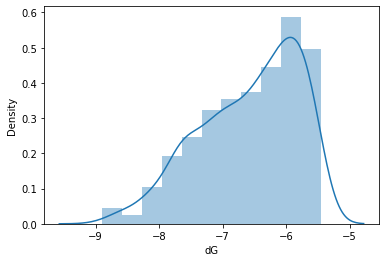

In [5]:
sns.distplot(data['dG'])

In [6]:
data[['SMILES','CID']].to_csv('smiles.smi')

In [7]:
from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

mols = [Chem.MolFromSmiles(smi) for smi in data['SMILES']]

In [8]:
# Get list of descriptors
descriptors_list = [a[0] for a in Chem.Descriptors.descList]
calculator = MolecularDescriptorCalculator(descriptors_list)
calc_descriptors = [calculator.CalcDescriptors(m) for m in mols]

In [9]:
df = pd.DataFrame(calc_descriptors, columns=descriptors_list)

In [10]:
df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.135814,-1.022707,14.135814,0.116928,0.308873,555.075,519.795,554.229598,208,0,...,0,0,0,0,0,0,0,0,0,0
1,13.490509,-3.779742,13.490509,0.010989,0.587016,485.993,461.801,485.117605,172,0,...,0,1,0,0,0,0,0,0,0,0
2,14.256120,-1.003594,14.256120,0.144602,0.273005,592.100,557.828,591.236080,220,0,...,0,0,0,0,0,0,0,0,0,0
3,13.843030,-0.460244,13.843030,0.198219,0.510128,450.905,430.745,450.137115,162,0,...,0,0,0,0,0,0,0,0,0,0
4,14.125541,-0.910110,14.125541,0.139021,0.353783,533.032,503.800,532.198966,196,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Compute the correlation matrix
corr = df.corr().abs()

# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
# Create correlation matrix

# Select upper triangle of correlation matrix
value=0.5
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find features with correlation greater than "value"
to_drop = [column for column in upper.columns if any(upper[column] > value)]

# Drop features 
df.drop(df[to_drop], axis=1,inplace=True)

In [12]:
df.head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_MRHI,...,fr_piperdine,fr_prisulfonamd,fr_quatN,fr_sulfide,fr_sulfone,fr_tetrazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.135814,-1.022707,0.116928,0.308873,0,0.407416,-0.493219,1.205128,9.743588,6.303554,...,0,0,0,0,0,0,0,0,0,0
1,13.490509,-3.779742,0.010989,0.587016,0,0.232833,-0.391723,1.151515,9.897554,7.893313,...,0,0,0,0,0,0,0,0,0,0
2,14.256120,-1.003594,0.144602,0.273005,0,0.407477,-0.493219,1.142857,9.743836,6.303564,...,0,0,0,0,0,0,0,0,0,0
3,13.843030,-0.460244,0.198219,0.510128,0,0.232793,-0.323637,1.250000,9.884614,6.302804,...,0,0,0,0,0,0,0,0,0,0
4,14.125541,-0.910110,0.139021,0.353783,0,0.236165,-0.493219,1.184211,9.743927,6.303542,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

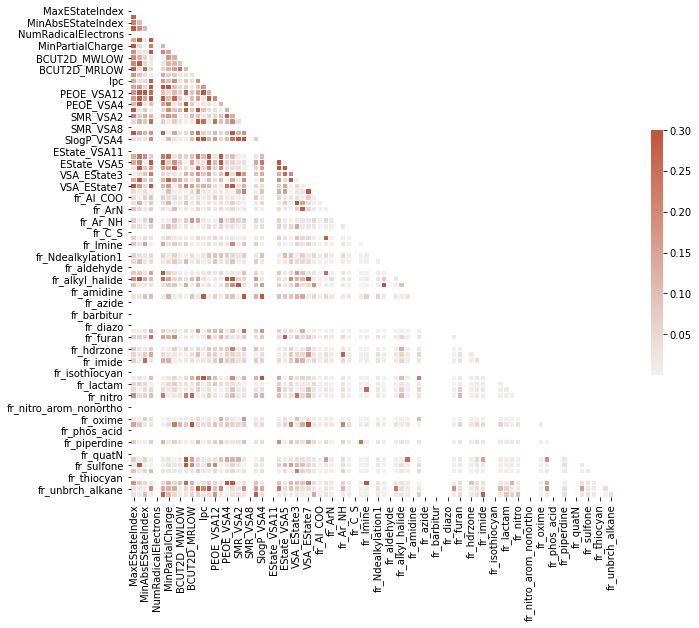

In [13]:
# Re-Compute the correlation matrix
corr = df.corr().abs()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



In [14]:
df.insert(0, column='CID', value=data['CID'].tolist())
df.insert(0, column='dG', value=data['dG'].tolist())

In [15]:
df.dropna(inplace=True)

In [16]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 0].values

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=20, random_state=42)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

In [20]:
from sklearn import metrics

print(f' MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f' MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
#print(" RF - Accuracy: %.2f%%" % (accuracy * 100.0))

 MAE: 0.52
 MSE: 0.45
RMSE: 0.67


/Users/dgomes/miniconda3/envs/modmol/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'dG pred')

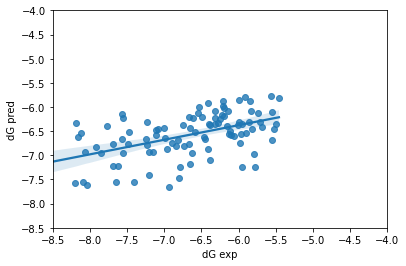

In [21]:
sns.regplot(y_test,y_pred)
plt.xlim(-8.5,-4)
plt.ylim(-8.5,-4)
plt.xlabel('dG exp')
plt.ylabel('dG pred')

/Users/dgomes/miniconda3/envs/modmol/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'dG pred')

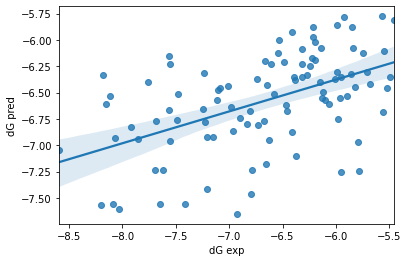

In [22]:
sns.regplot(y_test,y_pred)
#plt.xlim(-10.0,-5.5)
#plt.ylim(-10.0,-5.5)
plt.xlabel('dG exp')
plt.ylabel('dG pred')

In [23]:
# XGBoost

In [25]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

/Users/dgomes/miniconda3/envs/modmol/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

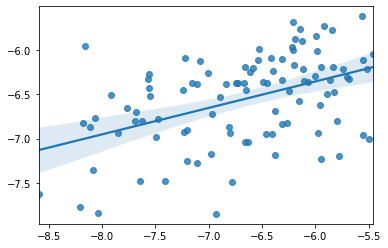

In [27]:
sns.regplot(y_test,y_pred)

In [28]:
from sklearn import metrics

print(f' MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f' MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
#print(" RF - Accuracy: %.2f%%" % (accuracy * 100.0))

 MAE: 0.57
 MSE: 0.50
RMSE: 0.71


In [29]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(XGBRegressor(objective='reg:squarederror'), X, y, scoring='neg_mean_squared_error')
(-scores)**0.5

array([1.03094077, 0.80752264, 0.64294356, 0.77915515, 0.71733887])